In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import copy
%matplotlib inline
import os
import glob

## First download the preprocessed CMUDataset

The dataset is downloaded to [data/cmu_mocap](data/cmu_mocap).

## Preliminaries

Below we define a class for a skeleton. It will be initialized with the skeletal offsets as well as a kinematic tree (the different kinematic chains in the skeleton).

The base skeletal offsets characterizes the default human pose, with no rotations at any joint.

## Inverse and Forward kinematics
We denote by $R$ the rotation matrix and $T$ the translation vector associated with a bone. In particular, the translation matrix for each joint is exactly given by the skeletal offset vector. Joint locations are denoted by $j$.

The fundamental kinematic chain equation is the following:
$$\left(\begin{matrix}R_0 & T_0 \\ 0 & 1\end{matrix}\right)\cdots\left(\begin{matrix}R_{n} & T_{n} \\ 0 & 1\end{matrix}\right)\left(\begin{matrix} 0 \\ 1\end{matrix}\right) = \left(\begin{matrix} j_n \\ 1\end{matrix}\right)$$
which is equivalent to the following:
$$j_n = R_0\cdots R_{n-1} T_n + j_{n-1}.$$

With the above, we are ready to implement the inverse and forward kinematics functions.

In [2]:
def RtoLie(R):
    '''Returns the axis angle aka lie algebra parameters from a rotation matrix'''
    theta = np.arccos((np.trace(R) - 1) / 2.0)
    if theta < 1e-6:
        A = np.zeros(3)
    else:
        A = theta / (2 * np.sin(theta)) * np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
    return A

def LietoR(A):
    '''Returns the rotation matrix from lie algebra parameters'''
    theta = np.linalg.norm(A)
    if theta == 0:
        R = np.identity(3)
    else:
        A = A / theta
        cross_matrix = np.array([[0, -A[2], A[1]], [A[2], 0, -A[0]], [-A[1], A[0], 0]])
        R = np.identity(3) + np.sin(theta) * cross_matrix + (1 - np.cos(theta)) * np.matmul(cross_matrix, cross_matrix)
    return R

def findrot(u, v):
    '''find the axis angle parameters to rotate unit vector u onto unit vector v'''
    w = np.cross(u, v)
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-6:
        A = np.zeros(3)
    else:
        A = w / w_norm * np.arccos(np.dot(u, v))
    return A

def eulertoR(angle):
    '''Returns the rotation matrix from euler angle parameters'''
    a = angle[0]
    b = angle[1]
    c = angle[2]

    a1 = np.array([1, 0, 0])
    a2 = np.array([0, np.cos(a), -np.sin(a)])
    a3 = np.array([0, np.sin(a), np.cos(a)])

    A = np.array([a1, a2, a3])

    b1 = np.array([np.cos(b), 0, np.sin(b)])
    b2 = np.array([0, 1, 0])
    b3 = np.array([-np.sin(b), 0, np.cos(b)])

    B = np.array([b1, b2, b3])

    c1 = np.array([np.cos(c), -np.sin(c), 0])
    c2 = np.array([np.sin(c), np.cos(c), 0])
    c3 = np.array([0, 0, 1])

    C = np.array([c1, c2, c3])

    R = np.matmul(np.matmul(A, B), C)

    return R

class Skeleton:
    def __init__(self, kinematic_tree, offsets, parents):
        # We first define the skeleton for H3.6m
        self._kinematic_tree = kinematic_tree
        self._offsets = offsets
        self._njoints = offsets.shape[0]
        self._raw_offsets = copy.deepcopy(offsets)
        for i in range(self._njoints):
            n = np.linalg.norm(self._raw_offsets[i])
            if n > 0:
                self._raw_offsets[i] = self._raw_offsets[i]/n
        
        self._parents = parents
                
    def njoints(self):
        return self._njoints
    
    def kinematic_tree(self):
        return self._kinematic_tree

    def raw_offsets(self):
        return self._raw_offsets
    
    def offsets(self):
        return self._offsets
        
    def parents(self):
        return self._parents
    
    def get_bonelengths(self, joints):
        '''This adjusts the bone lengths according to the joints'''
        for i in range(1, len(self._raw_offsets)):
            self._offsets[i] = np.linalg.norm(joints[i] - joints[self._parents[i]]) * self._raw_offsets[i]

    def forward_kinematics(self, lie_params):
        joints = np.zeros([self._njoints, 3])
        R = np.zeros([self._njoints, 3, 3])
        for i in range(self._njoints):
            if self._parents[i] == -1:  # Root node
                R[i] = np.eye(3)
            else:
                joints[i] = self._offsets[i].dot(R[self._parents[i]]) + joints[self._parents[i]]
                R[i] = LietoR(lie_params[i]).dot(R[self._parents[i]])
        return joints
    
    def plot(self, joints):
        plt.figure()
        limits = 1200
        ax = plt.axes(xlim=(-limits,limits), ylim=(-limits,limits), zlim=(-limits,limits), projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=120, azim=-90)
        ax.scatter(joints[:,0], joints[:,1], joints[:,2], color='black')
        colors = ['red', 'yellow', 'black', 'green', 'blue']
        for chain, color in zip(self._kinematic_tree, colors):
            ax.plot3D(joints[chain,0], joints[chain,1], joints[chain,2], linewidth=2.0, color=color)


## Initialze Skeleton class with following parameters

In [3]:
# Define a kinematic tree for the skeletal struture
# Left leg, Right leg, Spine, Left arm, Right arm
kinematic_tree = [[1, 2, 3, 4, 5, 6], [7 ,8, 9, 10, 11, 12], [13, 14, 15, 17, 18, 19], [15, 21, 22, 23, 25, 26, 23, 28], [15, 30, 31, 32, 34, 35, 32, 37]]
kinematic_tree = [np.arange(1,7), np.arange(7,13), np.arange(13,20), np.arange(20,29), np.arange(29,38)]
parents = np.array([-1,  0,  1,  2,  3,  4,  5,  0,  7,  8,  9, 10, 11, 0, 13, 14, 15, 16, 17, 18, 15, 20, 21, 22, 23, 24, 25, 23, 27, 15, 29, 30, 31, 32, 33, 34, 32, 36])
offsets = np.array([[   0. ,    0. ,    0. ],
                    [   0. ,    0. ,    0. ],
                    [ 116. , -126.2,   43.7],
                    [ 181.8, -499.5,    0. ],
                    [ 174.5, -479.3,    0. ],
                    [  13.8,  -37.9,  150.2],
                    [   0. ,    0. ,   77.9],
                    [   0. ,    0. ,    0. ],
                    [-116. , -126.2,   43.7],
                    [-181.8, -499.5,    0. ],
                    [-174.5, -479.3,    0. ],
                    [ -13.8,  -37.9,  150.2],
                    [   0. ,    0. ,   77.9],
                    [   0. ,    0. ,    0. ],
                    [   1.4,  143.8,   -9.9],
                    [   0.7,  144.5,   -4.1],
                    [   0. ,    0. ,    0. ],
                    [   0.5,  109.7,   10.5],
                    [   2.4,  109.2,   -7. ],
                    [   0.9,  113.8,   -3.7],
                    [   0. ,    0. ,    0. ],
                    [ 247.9,   63.3,  -12.2],
                    [ 340.6,    0. ,    0. ],
                    [ 234.9,    0. ,    0. ],
                    [   0. ,    0. ,    0. ],
                    [  46.3,    0. ,    0. ],
                    [  37.3,    0. ,    0. ],
                    [   0. ,    0. ,    0. ],
                    [  37.9,    0. ,   37.9],
                    [   0. ,    0. ,    0. ],
                    [-247.9,   63.3,  -12.2],
                    [-340.6,    0. ,    0. ],
                    [-234.9,    0. ,    0. ],
                    [   0. ,    0. ,    0. ],
                    [ -46.3,    0. ,    0. ],
                    [ -37.3,    0. ,    0. ],
                    [   0. ,    0. ,    0. ],
                    [ -37.9,    0. ,   37.9]])

human_skel = Skeleton(kinematic_tree, offsets, parents)


## Load the same pose parameterized in lie parameters

We apply forward kinematics and plot this pose.

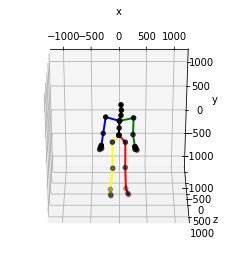

In [5]:
data = sio.loadmat('Data/cmu_mocap/Train/jumping_1.mat')['lie_parameters']
frame = 0
lie_params = np.reshape(data[frame], [-1,3])
joints_fwd = human_skel.forward_kinematics(lie_params)
human_skel.plot(joints_fwd)